# MFRE Data Analytics Coordinator Teaching Seminar: 

## How does the CAD/USD exchange rate affect real food prices?

October 26th, 2022

Harry Izatt


- Empirical work is about 90% data cleaning, 10% modelling

- Knowing the fundamentals of how to clean and manipulate data is vital for any economics project, and allows you to use more advanced econometric techniques. 

- Techniques I'll cover:

- - Reading data into a Jupyter Notebook
- - Groupby aggregations
- - Assigning and modifying variables in a Pandas dataframe
- - Merging dataframes
- - Dropping columns from a dataframe
- - Running a regression in Statsmodels

To replicate this, create a folder, and download the CPI and EXCAUS data into it. Right-click the folder, click "Properties", then "Security", then copy+paste the "Object name" into the `os.chdir()` brackets, addind a second \ to each one. 

In [1]:
# installing packages and setting path to working directory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

path="C:\\Users\\jonah\\Documents\\Career\\MFRE\\working_df"
os.chdir(path)

# First: Reading in Datasets

This is done with the pd.read_csv() command, with a "file.csv" going inside the brackets. 

This files must be in the working directory you set above!

In [2]:
# exchange rate dataframe
excaus_df = pd.read_csv("excaus_df.csv")
# reading in the CPI dataframe
cpi_df = pd.read_csv("18100004.csv")

C:\Users\jonah\AppData\Local\Temp\ipykernel_40788\3451709600.py:4: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  cpi_df = pd.read_csv("18100004.csv")


# Economic Understanding

`excaus_df` is from the Federal Reserve Economic Data (FRED) database. 

- It states the exchange rate of Canadian dollars per US dollar at a monthly level from 1971 onwards. 
- The higher the EXCAUS value, the more Canadian dollars it takes to equal one US dollar. 
- A higher value indicates a stronger USD relative to the Canadian dollar, while a lower value suggests the USD weakening relative to the Canadian dollar.

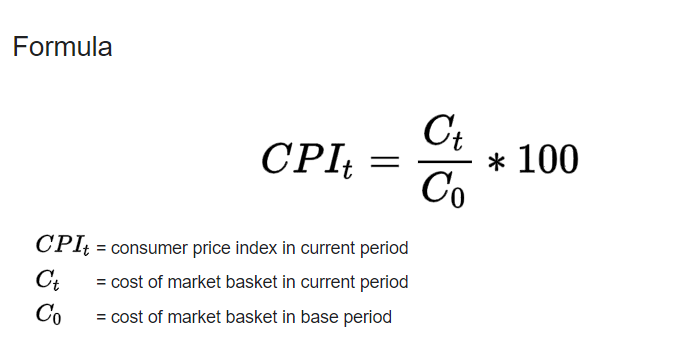

`cpi_df` is the Bank of Canada's general monthly Consumer Price Index covering data across many geographies. The CPI is calculated by taking the value of a fixed basket of goods, setting a base year price, and dividing each other year's basket price by the base year price and multiplying by 100. This gives an estimate of how the overall price level has changed since the base year.

For example, take a basket of 5 apples and 5 oranges.

- in the base year, Apples are \\$1 and Oranges are \\$2 each, therefore the base year basket price is \\$15
- the next year, Apples are \\$1.1 and Oranges are \\$2.50, therefore the next year's basket price is \\$18

It is trivial to show the base year's CPI is 100: \\$15/\\$15*100 = 100.

Next year's CPI is: \\$18/\\$15*100 = 120.

CPI's increase by a factor of 1.2 suggests 20% yearly inflation.

# Data Understanding and Basic Setup

### Aggregations with Groupby

Due to the varied geographies covered in `cpi_df`, I want to check what these are, and what their time coverages are.

A `df.groupby(col)` command lets us pass in a dataframe into `df`, a column to group by in `col`, and an aggregation function just afterwards. It treats every unique `col` value as its own group, then applies the aggregation function to each of them and displays the results. 

You can access a specific column in a dataframe with `dataframe_name`["column_name"], or a set of columns with `dataframe_name[["column1", "column2"]]`

Here, I group by geography, and take the minimum value. I only display the `REF_DATE` column, so the `.min()` function shows us the minimum value, i.e., the earliest covered date. 

In [3]:
cpi_df[["GEO", "REF_DATE"]].groupby("GEO").min()
#cpi_df[["GEO", "REF_DATE"]].groupby("GEO").max()

,REF_DATE
GEO,
Alberta,1978-09
British Columbia,1978-09
"Calgary, Alberta",1971-01
Canada,1914-01
"Charlottetown and Summerside, Prince Edward Island",1974-01
"Edmonton, Alberta",1971-01
"Halifax, Nova Scotia",1971-01
"Iqaluit, Nunavut",2002-12
Manitoba,1978-09


- We have Canada overall, provinces, and specified important cities, each with its own CPI. 

- Canada overall has CPI data reaching back to 1914, 
- The provinces generally cover from 1978 onwards

The cell directly above takes the latest month covered for each geography - it's September 2022 for every unit, so I've commented it out. 

### Conditional Filtering

Since we're just interested in provinces, I'm going to subset `cpi_df`. This is called **conditional filtering**, limiting a big dataset to a smaller subset of its rows which fulfill a given condition. Here I will subset to:


- `prov_cpi`, with Canadian provinces for `GEO` values

In [4]:
# creating list of province names
province_list = ["Alberta", "British Columbia", "Saskatchewan", "Manitoba", "Ontario", "Quebec", 
                 "New Brunswick", "Newfoundland and Labrador", "Nova Scotia", "Prince Edward Island"]

# creating subset dataframe only where `GEO` is in the list of provinces
# cpi_df["GEO"].isin(province_list) returns True for every row with "GEO" value in province_list
# then passing it into cpi_df[] square brackets returns the rows with True and discards those with False
prov_cpi = cpi_df[cpi_df["GEO"].isin(province_list)]

This is every row of `cpi_df` where the row's `GEO` value is a province name!

# Analysis topic: How does the monthly exchange rate affect CPI growth, conditioning on food categories and provincial regions?

What we're building towards is a regression model, to find the effect of the exchange rate on Real Food CPI values, while accounting for product and province fixed effects. 

My outcome variable will be `real_food_cpi`, equal to the specific type's CPI divided by `All-items cpi` and multiplied by 100. 

To do this, we need to do several steps of data processing:

1. Assign provincial region **dummy variables** (for Western and Eastern, with Central as the base case)
2. **Subset** to rows with food value entries in the `Products and product groups` column
3. Attaching exchange rate and `all-items` values with a **merge**  or **join** command
4. Find real_cpi by **dividing** the specific food type CPI by `All-items` and **multiplying** by 100
5. Running a **Regression** with Statsmodels
 - Setting up OLS dataframe
 - Running regression
 - Discussing results

# Data Preparation

# 1. Assigning regional dummy variables

In [5]:
# creating variables

# you create variables in a dataframe with the format of dataframe_name["column_name"] = <value>
prov_cpi["eastern"] = 0
prov_cpi["central"] = 0
prov_cpi["western"] = 0

# setting to 1 based on region

# the .loc[] command allows us to set modified values for rows that fit a given category
# the first argument specifies the condition - that the "GEO" value matches a given province
# the second argument is what column to change
# lastly we show what value to change to; in each case here it's 1
prov_cpi.loc[prov_cpi["GEO"] == "Newfoundland and Labrador", "eastern"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "Prince Edward Island", "eastern"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "Nova Scotia", "eastern"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "New Brunswick", "eastern"] = 1

prov_cpi.loc[prov_cpi["GEO"] == "Ontario", "central"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "Quebec", "central"] = 1

prov_cpi.loc[prov_cpi["GEO"] == "British Columbia", "western"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "Alberta", "western"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "Manitoba", "western"] = 1
prov_cpi.loc[prov_cpi["GEO"] == "Saskatchewan", "western"] = 1


C:\Users\jonah\AppData\Local\Temp\ipykernel_40788\3584014297.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prov_cpi["eastern"] = 0
C:\Users\jonah\AppData\Local\Temp\ipykernel_40788\3584014297.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prov_cpi["central"] = 0
C:\Users\jonah\AppData\Local\Temp\ipykernel_40788\3584014297.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

# 2. **Subsetting** to food types and `All-items`

We want:

One dataframe with `Products and product groups` values of:
- "Food"
- "Bakery and cereal products (excluding baby food)"
- "Dairy products and eggs"
- "Meat"
- "Vegetables and vegetable preparations"

And another dataframe with just "All-items" to be merged with the above, and used to calculate Real CPI.

We'll do this with **Conditional Filtering**, just like how we made `prov_cpi`.

In [6]:
# make list of food products
foods = ["Food", "Bakery and cereal products (excluding baby food)", "Dairy products and eggs", "Meat", "Vegetables and vegetable preparations"]
# filter to the rows with a `Products and product groups` value in the `foods` list
food_cpi = prov_cpi[prov_cpi["Products and product groups"].isin(foods)]

# filtering to the rows with a `Products and product groups` of "All-items"
all_items = prov_cpi[prov_cpi["Products and product groups"] == "All-items"]
all_items.head()

,REF_DATE,GEO,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS,eastern,central,western
39784,1978-09,Newfoundland and Labrador,2016A000210,All-items,2002=100,17,units,0,v41691244,3.2,38.6,NaN,NaN,NaN,1,1,0,0
39894,1978-09,Prince Edward Island,2016A000211,All-items,2002=100,17,units,0,v41691379,5.2,39.3,NaN,NaN,NaN,1,1,0,0
40002,1978-09,Nova Scotia,2016A000212,All-items,2002=100,17,units,0,v41691513,7.2,38.2,NaN,NaN,NaN,1,1,0,0
40112,1978-09,New Brunswick,2016A000213,All-items,2002=100,17,units,0,v41691648,9.2,38.2,NaN,NaN,NaN,1,1,0,0
40222,1978-09,Quebec,2016A000224,All-items,2002=100,17,units,0,v41691783,11.2,37.6,NaN,NaN,NaN,1,0,1,0


In [7]:
print(food_cpi["UOM"].unique())
print(all_items["UOM"].unique())

['2002=100']
['2002=100']


Using the `.unique()` method on a column returns all unique values in it. 

Since there's only one in each, and for both they have the same base year, we know we can compare all of the relevant CPI values!

# 3. **Merging** exchange rates and `all_items` onto `foods_cpi`

**Merging** and **Joining** are ways of adding data from one dataframe to another, by matching rows with the same values in one or more columns. 

This lets us match the CPI data with the exchange rates from the same year and month. 

This will require making columns that match every year-month entry of `foods_cpi` and `excaus_df`, and every province-year-month for `foods_cpi` and `all_items`. 

First I will match to `excaus_df` to bring in the exchange rate. 

In [8]:
food_cpi["REF_DATE"].head()

39785    1978-09
39787    1978-09
39794    1978-09
39799    1978-09
39803    1978-09
Name: REF_DATE, dtype: object

In [9]:
excaus_df.head()
#type(excaus_df["DATE"][0])

,DATE,EXCAUS
0,1971-01-01,1.0118
1,1971-02-01,1.0075
2,1971-03-01,1.0064
3,1971-04-01,1.0077
4,1971-05-01,1.0087


As we can see, `food_cpi` has date marked just by year-month, while `excaus_df` uses the first day of every month. If I drop the day entry of `excaus_df`, I can match it with `food_cpi` on `DATE` and `REF_DATE`

In [10]:
# this turns the "DATE" column from a date format to a string format, then takes the first 7 characters, and sets that as a new "REF_DATE" column
excaus_df["REF_DATE"] = excaus_df['DATE'].astype(str).str[:7]

# this drops the original column
# if you set `axis` to 0, you can drop rows instead
excaus_df.drop("DATE", axis=1, inplace=True)
excaus_df

,EXCAUS,REF_DATE
0,1.0118,1971-01
1,1.0075,1971-02
2,1.0064,1971-03
3,1.0077,1971-04
4,1.0087,1971-05
...,...,...
616,1.2859,2022-05
617,1.2804,2022-06
618,1.2936,2022-07
619,1.2917,2022-08


In [11]:
# joining `excaus_df` to `food_cpi`

food_cpi = food_cpi.merge(excaus_df, on="REF_DATE")
food_cpi.columns

Index(['REF_DATE', 'GEO', 'DGUID', 'Products and product groups', 'UOM',
       'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE',
       'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS', 'eastern', 'central',
       'western', 'EXCAUS'],
      dtype='object')

So, now we've got exchange rate added. Next, I need to merge in the `All-items` CPI, in the dataframe `all_items`

These two are structurally the same. However, I need them to be matched by not just date, but also geography. So, in my merge command, I'll be merging on a list of columns, `["REF_DATE", "GEO"]`. Since I don't want to bring every column across, I'm going to drop most columns from the `all_items` dataframe before merging, and rename the `VALUE` columns to `all_price_value` for clarity after merging.

In [12]:
# .copy() makes a new identical dataframe, in case you don't want to overwrite the current one
all_items_merge = all_items.copy()

# .drop() removes specified columns if the axis argument is set equal to 1, or rows if set equal to 0
# setting `inplace=True` makes it apply the function to the dataframe's value, 
# rather than just returning a copy with the function applied but leaving the original unchanged
all_items_merge.drop(["DGUID", 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 
                      'COORDINATE', "SYMBOL", "TERMINATED", "DECIMALS", 'eastern', 'central',
                      'western', "STATUS", "Products and product groups"], axis=1, inplace=True)
all_items_merge.rename(columns={"VALUE": "all_price_value"},inplace=True)                      
all_items_merge

,REF_DATE,GEO,all_price_value
39784,1978-09,Newfoundland and Labrador,38.6
39894,1978-09,Prince Edward Island,39.3
40002,1978-09,Nova Scotia,38.2
40112,1978-09,New Brunswick,38.2
40222,1978-09,Quebec,37.6
...,...,...,...
1058061,2022-09,Ontario,154.1
1058211,2022-09,Manitoba,155.2
1058351,2022-09,Saskatchewan,155.7
1058496,2022-09,Alberta,160.1


In [13]:
# now merging all-items CPI onto food_cpi
# merging on ["REF_DATE", "GEO"] because the CPI values have to match in both timing and geography
all_food_cpi = food_cpi.merge(all_items_merge, on=["REF_DATE", "GEO"])
all_food_cpi.columns

Index(['REF_DATE', 'GEO', 'DGUID', 'Products and product groups', 'UOM',
       'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE',
       'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS', 'eastern', 'central',
       'western', 'EXCAUS', 'all_price_value'],
      dtype='object')

# 4. Calculating `real_cpi` from `VALUE` and `all_price_value`

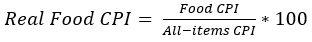

This involves dividing the specific food CPIs (in the `VALUE` column) by the all-prices CPI.

You can do math with dataframe columns - just use the relevant mathematical operators (+-*/). Python will do the manipulations between the same-row elements of each column.

In [14]:
# this divides food CPI by the all-price CPI column, then multiplies by 100 
all_food_cpi["real_cpi"] = (all_food_cpi["VALUE"]/all_food_cpi["all_price_value"])*100

# this drops unnecessary columns, passed in as a list
all_food_cpi.drop(['DGUID', "UOM", "UOM_ID", "SCALAR_FACTOR", "SCALAR_ID", "VECTOR", 
                   "COORDINATE", "STATUS", "SYMBOL", "TERMINATED", "DECIMALS"], 
                   axis= 1, inplace=True)
all_food_cpi

,REF_DATE,GEO,Products and product groups,VALUE,eastern,central,western,EXCAUS,all_price_value,real_cpi
0,1978-09,Newfoundland and Labrador,Food,44.1,1,0,0,1.1664,38.6,114.248705
1,1978-09,Newfoundland and Labrador,Meat,49.3,1,0,0,1.1664,38.6,127.720207
2,1978-09,Newfoundland and Labrador,Dairy products and eggs,43.1,1,0,0,1.1664,38.6,111.658031
3,1978-09,Newfoundland and Labrador,Bakery and cereal products (excluding baby food),37.9,1,0,0,1.1664,38.6,98.186528
4,1978-09,Newfoundland and Labrador,Vegetables and vegetable preparations,41.4,1,0,0,1.1664,38.6,107.253886
...,...,...,...,...,...,...,...,...,...,...
26445,2022-09,British Columbia,Food,168.4,0,0,1,1.3339,147.8,113.937754
26446,2022-09,British Columbia,Meat,191.4,0,0,1,1.3339,147.8,129.499323
26447,2022-09,British Columbia,Dairy products and eggs,160.0,0,0,1,1.3339,147.8,108.254398
26448,2022-09,British Columbia,Bakery and cereal products (excluding baby food),168.1,0,0,1,1.3339,147.8,113.734777


What we have now is a dataframe with date, geography, product type, raw product CPI, dummy variables for region, monthly exchange rate, all_price CPI, and `real_cpi` calculated from the specific food's CPI and all-price CPI.  

# Is it enough to visualize CPI trends over time?

With 5 products, 10 provinces, 3 regions, and 44 years, we're going to have to visualize a subset of the date. I'll be using the overall `Food` real CPI, showing the 3 regions over time. Anything more is too many lines to interpret!

This section is lengthy, and the answer to the above is ultimately "not very." 

I'll show the visualization I reached, but the details of the code have been minimized. 

In [15]:
# subsetting by food type

just_food_cpi = all_food_cpi[all_food_cpi["Products and product groups"] == "Food"]

# also subsetting the others
# these are unused but could be plugged in instead!
meat_cpi = all_food_cpi[all_food_cpi["Products and product groups"] == "Meat"]
dairy_cpi = all_food_cpi[all_food_cpi["Products and product groups"] == "Dairy products and eggs"]
bakery_cpi = all_food_cpi[all_food_cpi["Products and product groups"] == "Bakery and cereal products (excluding baby food"]
vegetable_cpi = all_food_cpi[all_food_cpi["Products and product groups"] == "Vegetables and vegetable preparations"]

# pivoting: indexed by date, each column is the values of food's real cpi for that time and geography 
geo_food = pd.pivot_table(data=just_food_cpi, index = "REF_DATE", columns="GEO", values="real_cpi")
#geo_food

In [16]:
# 10 provinces is too many time trends to visualize 
# I'm averaging across regions to make `region_food` which can be visualized

region_food = geo_food.reset_index()
region_food["east"] = region_food["New Brunswick"] + region_food["Newfoundland and Labrador"] + region_food["Nova Scotia"] + region_food["Prince Edward Island"]
region_food["east"] = region_food["east"]/4

region_food["central"] = region_food["Ontario"] + region_food["Quebec"]
region_food["central"] = region_food["central"]/2

region_food["west"] = region_food["Alberta"] + region_food["British Columbia"] + region_food["Manitoba"] + region_food["Saskatchewan"] 
region_food["west"] = region_food["west"]/4

region_food.drop(["Alberta", "British Columbia", "Manitoba", "New Brunswick",
                  "Newfoundland and Labrador", "Prince Edward Island", "Nova Scotia",
                  "Ontario", "Quebec", "Saskatchewan"], axis=1, inplace=True)

dates = region_food["REF_DATE"]
dates = pd.to_datetime(dates)

#region_food
#region_food.set_index("REF_DATE")

In [17]:
#plt.style.use('ggplot')

#fig, ax = plt.subplots(1, 1, figsize = (25, 15))

#ax.xaxis.set_major_locator(plt.MaxNLocator(45))

#plt.plot(dates, region_food["east"])
#plt.plot(dates, region_food["west"])
#plt.plot(dates, region_food["central"])

#ax.set_title("Regional Monthly Food CPI (1978-2022)", size = 25)
#ax.set_ylabel("Real Food CPI", fontsize=15, color="black")
#ax.set_xlabel("Year", fontsize=15, color="black")
#ax.legend(["East", "Central", "West"], prop={'size': 20})


![](plots/regional_monthly_1978_2022.png)

### **Line Plot Interpretation**

- U-shape: real food prices start high, fall to their level of 100 in the base year of 2002, and then rise again

**Real Food_X CPI is a fraction:**

![](real_food_cpi.png)


- Variation in the plot could be due to changes in Food CPI or All-items CPI
- Cannot judge just from the plot

- Post-2002, Central values consistently 3-5 CPI lower than West and East
- West and East highly variable

**Shows the limits of data visualization** 

- Making out anything more specific than very broad trends from such a visualization is impossible. 

If we want to see more precisely how time trends work, if the regions' differences are statistically significant, whether it varies by food type, and what role exchange rates play (if any), we need a more formal model. 

So, next we will run our regression.

## 5. Regression Model

#### A short explanation of linear regression:

Linear regression specifies a model such as the following:

![](linear%20regression.png)


It estimates coefficients (the Beta terms) that describe how the outcome variable is correlated with the explanatory variables. 

Each is a "best fit" when holding all other explanatory variables constant. 

What conditions the data must meet for a linear regression's coefficients of interest to be taken as *causal* are very important, but this is about applying programming to data rather than the theoretical econometrics, so I'll be sidestepping that bag of worms. 

Our dependent variable will be the real food CPI values, `real_cpi` in the datframe. 

As explanatory variables, I'll be using:

1. An intercept
2. Region dummy variable: `eastern` and `western` with `central` as the baseline
3. Product type dummy variables, with `Food` as the baseline
4. `EXCAUS`, the CAD/USD exchange rate

While prices rise overall with time (i.e. inflation), our outcome variable here is food CPI divided by overall CPI. There is no particular reason to think these are changing in any specific direction, so I'm not going to assume a time trend, which is why I don't use a variable for time elapsed.

### Regression Model Data Prep

In [18]:
# copying `all_food_cpi` to keep it around - we might want to do something else with it
reg_1_df = all_food_cpi.copy()
# assigning intercept
reg_1_df["intercept"] = 1
# creating product dummies
reg_1_df["Meat"] = 0
reg_1_df["Dairy"] = 0
reg_1_df["Bakery"] = 0
reg_1_df["Veg"] = 0
# assigning 1 to proper dummy variables
reg_1_df.loc[reg_1_df['Products and product groups'] == 'Meat', 'Meat'] = 1
reg_1_df.loc[reg_1_df['Products and product groups'] == 'Dairy products and eggs', 'Dairy'] = 1
reg_1_df.loc[reg_1_df['Products and product groups'] == 'Bakery and cereal products (excluding baby food)', 'Bakery'] = 1
reg_1_df.loc[reg_1_df['Products and product groups'] == 'Vegetables and vegetable preparations', 'Veg'] = 1

# dropping unnecessary columns
reg_1_df.drop(["REF_DATE", "GEO", "VALUE", "Products and product groups", "central", "all_price_value"], axis=1, inplace=True)

reg_1_df

,eastern,western,EXCAUS,real_cpi,intercept,Meat,Dairy,Bakery,Veg
0,1,0,1.1664,114.248705,1,0,0,0,0
1,1,0,1.1664,127.720207,1,1,0,0,0
2,1,0,1.1664,111.658031,1,0,1,0,0
3,1,0,1.1664,98.186528,1,0,0,1,0
4,1,0,1.1664,107.253886,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
26445,0,1,1.3339,113.937754,1,0,0,0,0
26446,0,1,1.3339,129.499323,1,1,0,0,0
26447,0,1,1.3339,108.254398,1,0,1,0,0
26448,0,1,1.3339,113.734777,1,0,0,1,0


In [19]:
# taking dependent variable, and explanatory variables, apart
reg_1_outcome = reg_1_df["real_cpi"]
reg_1_exog = reg_1_df.drop("real_cpi", axis=1)

In [20]:
# running regression model 1

reg_1 = sm.OLS(reg_1_outcome, reg_1_exog)
reg_1_result = reg_1.fit(cov_type="HC3")
reg_1_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               real_cpi   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     344.1
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        00:37:30   Log-Likelihood:                -98129.
No. Observations:               26450   AIC:                         1.963e+05
Df Residuals:                   26442   BIC:                         1.963e+05
Df Model:                           7                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
eastern        0.2395      0.171      1.399      0.162      -0.096       0.575
western       -1.5154      0.157     -9.637      0.000      -1.824      -1.207
EXCAUS       -13.1177      0.351    -37.349      0.000     -13.806     -12.429
intercept    121.3719      0.464    261.830      0.000     120.463     122.280
Meat          -0.2761      0.173     -1.599      0.110      -0.615       0.062
Dairy          1.3396      0.109     12.331      0.000       1.127       1.553
Bakery         4.4659      0.159     28.105      0.000       4.154       4.777
Veg           -1.1011      0.203     -5.429      0.000      -1.499      -0.704
==============================================================================
Omnibus:                     3293.198   Durbin-Watson:                   1.620
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6096.670
Skew:                           0.816   Prob(JB):                         0.00
Kurtosis:                       4.694   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

### Regression Interpretation

#### Regions

We use `central` as a baseline. 

- `eastern` provinces have higher real food CPI, with a coefficient of 0.2395, but it's not statistically significant. 
- `western` provinces have on average lower real food CPI by -1.5154 points, and with a near-0 p-value, implying high statistical significance. 

The model finds smaller average differences once accounting for other variables than we noticed from 2002 onwards in our visualization above, just of general food prices.

### Product Types

Compared to "All Food"; 
- `Dairy` and `Bakery` products average higher real CPI at high statistical significance
- `Meat` and `Veg` products average lower real CPI, but only the latter is statistically significant

### Exchange Rate

- `EXCAUS` has a negative coefficient and is highly statistically significant

Recall that a higher `EXCAUS` implies a weaker Canadian dollar relative to the US. The negative coefficient suggests the weaker the dollar gets, the lower our food real CPI types go.


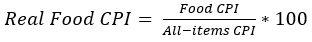

The nature of the Real Food CPI value might explain this. Food X's Real CPI is equal to Food X's CPI divided by All-Items CPI, then multiplied by 100. 

If we're more depenent on imports for general products than food, a weakening of the dollar means these prices in CAD are going to rise more than food prices, pushing up normal CPI by more than food CPI. Since increasing the denominator will lower overall Real Food CPI, this could explain the negative coeffient.  

In [21]:
print("Maximum, minimum, mean, std deviation of `EXCAUS`")
print("MAX: ", reg_1_exog["EXCAUS"].max())
print("MIN: ", reg_1_exog["EXCAUS"].min())
print("MEAN:", reg_1_exog["EXCAUS"].mean())
print("St. Dev:", reg_1_exog["EXCAUS"].std())

print("Maximum, minimum, mean of Real Food CPI Values")
print("MAX: ", reg_1_outcome.max())
print("MIN: ", reg_1_outcome.min())
print("MEAN:", reg_1_outcome.mean())
print("St. Dev:", reg_1_outcome.std())

Maximum, minimum, mean, std deviation of `EXCAUS`
MAX:  1.5997
MIN:  0.9553
MEAN: 1.2619385633270712
St. Dev: 0.14571217747861875
Maximum, minimum, mean of Real Food CPI Values
MAX:  181.5899581589958
MIN:  70.42410714285715
MEAN: 105.1934731081134
St. Dev: 10.289744536432528


### Exchange Rate Effect Size

Assessing the economic significance of the `EXCAUS` effect takes more work. 

- `EXCAUS` never goes below 0.95 or above 1.6. 
- An increase of `EXCAUS` by one standard deviation (0.146), multiplied by the effect size of -13.1177, suggests a fall of Real Food CPI by 2.01 points. 
- This is nearly 2% of the average Real Food CPI value (mean 105.19), but less than a fifth of its Standard Deviation (of 10.29).  

The magnitude of this effect depends on the level of Food Real CPI in the year it happens.  

- Even at the highest level of 181.60 it's still more than a 1% change, which will matter to households, and even more to producers. 
- Compare with the Bank of Canada's 2% inflation target

In [22]:
reg_1_exog

,eastern,western,EXCAUS,intercept,Meat,Dairy,Bakery,Veg
0,1,0,1.1664,1,0,0,0,0
1,1,0,1.1664,1,1,0,0,0
2,1,0,1.1664,1,0,1,0,0
3,1,0,1.1664,1,0,0,1,0
4,1,0,1.1664,1,0,0,0,1
...,...,...,...,...,...,...,...,...
26445,0,1,1.3339,1,0,0,0,0
26446,0,1,1.3339,1,1,0,0,0
26447,0,1,1.3339,1,0,1,0,0
26448,0,1,1.3339,1,0,0,1,0


In [23]:
#fig = sm.graphics.plot_partregress("real_cpi", "EXCAUS", ["Meat"], data=reg_1_df)
#fig.tight_layout(pad=1.0)
#fig.tight_layout()


(100.0, 175.0)

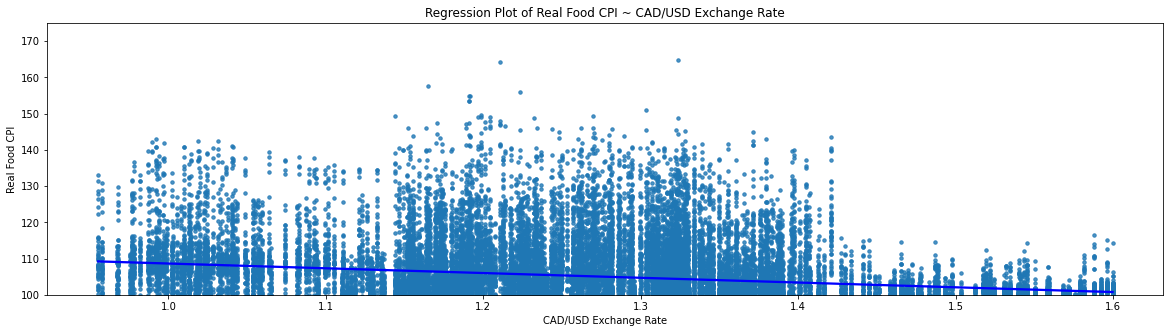

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (20,5))

regplot_exog = reg_1_exog.drop("EXCAUS", axis=1)

#sns.regplot(x = reg_1_exog["EXCAUS"], y = reg_1_outcome, data = regplot_exog,
#            y_partial = ["eastern", "western", "intercept", "Meat", "Dairy", "Bakery", "Veg"], 
#            line_kws={"color": "blue"}, scatter_kws={"s": 12})
sns.regplot(x = "EXCAUS", y = "real_cpi", data = reg_1_df,
           # x_partial = ["eastern", "western", "intercept", "Meat", "Dairy", "Bakery", "Veg"], 
            line_kws={"color": "blue"}, scatter_kws={"s": 12})


ax.set_title("Regression Plot of Real Food CPI ~ CAD/USD Exchange Rate")
ax.set_xlabel("CAD/USD Exchange Rate")
ax.set_ylabel("Real Food CPI")
ax.set_ylim(100, 175)